In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge
from scipy import stats
from sklearn.model_selection import StratifiedKFold
from scipy.stats import sem
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# Dataset

In [2]:
jerks_path = "Dataset/Appropriateness_Features/mean_jerk_values.csv"
XX_jerks = pd.read_csv(jerks_path) # With Spine joint and Name of "Cond/StudySeq"

accels_path = "Dataset/Appropriateness_Features/mean_acceleration_values.csv"
XX_accels = pd.read_csv(accels_path) # With Spine joint and Name of "Cond/StudySeq"

pairwise_path = "Dataset/Appropriateness_Features/mean_pairwise_joint_distances.csv"
XX_pairwise = pd.read_csv(pairwise_path) # With Spine joint and Name of "Cond/StudySeq"
XX_pairwise.drop(XX_pairwise.columns[range(1,15)], axis=1, inplace=True) # Without Spine Joint but with Name of "Cond/StudySeq"

rms_properties_path = "Dataset/Appropriateness_Features/RMS_Energy_properties.csv"
XX_rms_energy_properties = pd.read_csv(rms_properties_path, index_col = False) # With Name of StudySeq

rms_distance_path = "Dataset/Appropriateness_Features/RMS_Distance_scores_fd_scaled.csv"
XX_rms_distance_scores = pd.read_csv(rms_distance_path)
XX_rms_distance_scores.drop(XX_rms_distance_scores.columns[1], axis=1, inplace=True) # Dropping the Spine joint (always 0)

labels_path = "Dataset/Appropriateness_Labels/mean_opinion_scores.csv"
YY = pd.read_csv(labels_path) # # With Name of "Cond/StudySeq"

In [3]:
XY = XX_jerks.join(YY, lsuffix="_jerks", rsuffix="_YY")
XY = XY.join(XX_accels, rsuffix='_accels')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_accels'})
XY = XY.join(XX_pairwise, rsuffix='_pairwise')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_pairwise'})
XY = XY.join(XX_rms_distance_scores)
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_rms_distance_scores'})

In [4]:
# Join the RMS Energy Properties Features
XY = XY.rename(columns={'Unnamed: 0_jerks': 'StudySeq'})
XY['StudySeq'] = XY['StudySeq'].apply(lambda x: x[8:])
XY = XY.join(XX_rms_energy_properties, rsuffix='_rms')
for i in range(1,int(XY.shape[0]/40)):
    XY.iloc[i*40:(i+1)*40,-5:] = XX_rms_energy_properties

In [5]:
# Drop the Names of "Cond/StudySeq" and remaining information relating to the "Spine" joint
# Also Drop the Index from rms_energy
XY.drop(['StudySeq','Unnamed: 0_YY','Unnamed: 0_accels', 'Unnamed: 0_pairwise', 'Spine', 'Spine_accels',
        'Unnamed: 0_rms_distance_scores', 'Unnamed: 0', 'StudySeq_rms'], axis=1, inplace=True)

rename_dict = dict(zip(XY.columns[0:14], XY.columns[0:14] + '_jerks'))
XY = XY.rename(columns=rename_dict)

# Jerk for 14 joints + Acceleration for 14 joints + 14 choose 2 pairwise distance + 14 RMS Energy Distance Scores + 3 RMS Energy Property Features + Label for MOS = 137
print(XY.shape)

(360, 137)


In [6]:
XX = XY.drop(['Mean_Appropriateness_Score'], axis=1, inplace=False)
bad_features = ['LeftShoulder_vs_LeftArm', 'LeftArm_vs_LeftForeArm', 'LeftForeArm_vs_LeftHand',
                'RightShoulder_vs_RightArm', 'RightArm_vs_RightForeArm','RightForeArm_vs_RightHand']
XX.drop(bad_features, axis=1, inplace=True)
YY = XY.loc[:,'Mean_Appropriateness_Score']
XX = np.log(XX)
XX.iloc[:,-17:-3] = XX.iloc[:,-17:-3]
print(XX.shape)
print(YY.shape)

(360, 130)
(360,)


In [7]:
XX_train, XX_test, YY_train, YY_test = train_test_split(XX, YY, test_size=0.2)

# Univariate Feature Selection

([<matplotlib.axis.XTick at 0x2245b58c040>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

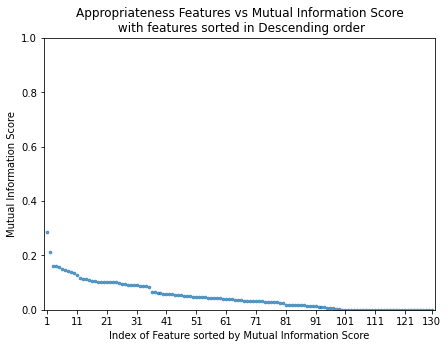

In [25]:
scores = mutual_info_regression(XX_train, YY_train, discrete_features = False)
plt.figure(figsize=(7,5))
plt.scatter(np.arange(1,131), np.flip(np.sort(scores)), s=7, alpha = 0.7)
plt.xlim(0,131)
plt.ylim(0,1)
plt.title('Appropriateness Features vs Mutual Information Score\n with features sorted in Descending order')
plt.xlabel('Index of Feature sorted by Mutual Information Score')
plt.ylabel('Mutual Information Score')
plt.xticks(np.append(np.arange(1,131,10),130))

# Functions

In [9]:
def reduce_by_fs_score(XX, YY, threshold):
    scores = mutual_info_regression(XX, YY, discrete_features = False)
    reduced_XX = XX.drop(XX.columns[np.where(scores < threshold)], axis=1, inplace=False)
    return reduced_XX

In [10]:
def feature_curve(model_name, model, XX, YY, param_grid, xticks):
    n_splits = 5
    outer_loop_cv = KFold(n_splits = n_splits, shuffle = True)
    outer_val_mse = []
    outer_train_mse = []
    folds = outer_loop_cv.split(XX)
    count = 1
    for train, test in folds:
        XX_train = XX.iloc[train]
        YY_train = YY.iloc[train]
        YY_train = YY_train.values.flatten()
        
        val_scores = []
        train_scores = []
        for threshold in param_grid:
            reduced_XX_train = reduce_by_fs_score(XX_train, YY_train, threshold)
            cv_results = cross_validate(model, reduced_XX_train, YY_train,scoring = "neg_mean_squared_error",
                                               cv=KFold(n_splits = n_splits, shuffle = True), return_train_score=True)
            val_scores = val_scores + [-1 * np.mean(cv_results['test_score'])]
            train_scores = train_scores + [-1 * np.mean(cv_results['train_score'])]

        outer_val_mse = outer_val_mse + [val_scores]
        outer_train_mse = outer_train_mse + [train_scores]
        print('Fold ', count, '/', n_splits, ' Complete.')
        count = count + 1
        
    mean_val_mse = np.mean(np.asarray(outer_val_mse), axis=0)
    mean_train_mse = np.mean(np.asarray(outer_train_mse), axis=0)
    
    plt.figure(figsize=(6,4))
    plt.plot(param_grid, mean_train_mse, label='MSE on Training Set')
    plt.plot(param_grid, mean_val_mse, label='MSE on Validation Set')
    plt.xlim(min(param_grid), max(param_grid))
    plt.xticks(xticks)
    plt.ylim(0, max(mean_val_mse) + max(mean_val_mse)*0.05)
    plt.ylabel('MSE')
    plt.xlabel('Mutual Information Score Threshold')
    plt.title(model_name + ' performance on \nvarying Mutual Information Score Threshold')
    plt.legend()
    
    print('Best Mutual Information Score Threshold: ', param_grid[np.where(mean_val_mse == (min(mean_val_mse)))[0]])

In [11]:
def validation_curve(model_name, model, XX, YY, param_grid, log_bool, extra_string, xticks):
    n_splits = 5
    outer_loop_cv = KFold(n_splits = n_splits, shuffle = True)
    outer_val_mse = []
    outer_train_mse = []
    folds = outer_loop_cv.split(XX)
    count = 1
    for train, test in folds:
        XX_train = XX.iloc[train]
        YY_train = YY.iloc[train]
        YY_train = YY_train.values.flatten()
        
        cv_model = GridSearchCV(estimator = model, param_grid = param_grid, scoring = "neg_mean_squared_error", 
                                    cv = KFold(n_splits = 5, shuffle = True), return_train_score=True)
        cv_model.fit(XX_train, YY_train)
        
        train_mse = -1 * cv_model.cv_results_["mean_train_score"]
        val_mse = -1 * cv_model.cv_results_["mean_test_score"]
        
        outer_train_mse = outer_train_mse + [train_mse]
        outer_val_mse = outer_val_mse + [val_mse]
        print('Fold ', count, '/', n_splits, ' Complete.')
        count = count + 1
        
    mean_train_mse = np.mean(np.asarray(outer_train_mse), axis=0)
    mean_val_mse = np.mean(np.asarray(outer_val_mse), axis=0)
    
    train_mse_sem = sem(np.asarray(outer_train_mse), axis=0)
    val_mse_sem = sem(np.asarray(outer_val_mse), axis=0)
    
    param_list = list(np.concatenate(list(param_grid.values())).flat)
    
    plt.figure(figsize = (6,4))
    plt.plot(param_list, mean_train_mse, label='Training Set MSE')
    plt.fill_between(param_list, mean_train_mse - train_mse_sem, mean_train_mse + train_mse_sem, alpha=0.5)
    plt.plot(param_list, mean_val_mse, label='Validation Set MSE')
    plt.fill_between(param_list, mean_val_mse - val_mse_sem, mean_val_mse + val_mse_sem, alpha=0.5)
    if log_bool == True:
        plt.xscale('log')
    plt.xlim(min(param_list),max(param_list))
    plt.xticks(xticks)
    plt.ylim(0, max([max(mean_train_mse), max(mean_val_mse)]) + max([max(train_mse_sem), max(val_mse_sem)]))
    plt.ylabel('MSE')
    plt.xlabel(list(param_grid.keys())[0])
    plt.title(model_name + ' performance on varying ' + list(param_grid.keys())[0] + extra_string)
    plt.legend()
    

In [12]:
# Model name is just the type of algorithm e.g. Linear Regression or kNN
def predicted_vs_true(model_name, model, XX, YY):
    n_splits = 5
    outer_loop_cv = KFold(n_splits = n_splits, shuffle = True)
    folds = outer_loop_cv.split(XX)
    count = 1
    YY_train_true = []
    YY_train_preds = []
    YY_preds = []
    YY_true = []
    for train, test in folds:
        XX_train = XX.iloc[train]
        YY_train = YY.iloc[train]
        XX_test= XX.iloc[test]
        YY_test = YY.iloc[test]
        YY_train, YY_test = YY_train.values.flatten(), YY_test.values.flatten()
        
        model.fit(XX_train, YY_train)
        
        YY_train_preds = YY_train_preds + list(model.predict(XX_train))
        YY_train_true = YY_train_true + list(YY_train)
        
        YY_pred = model.predict(XX_test)
        
        YY_true = YY_true + list(YY_test)
        YY_preds = YY_preds + list(YY_pred)
        print('Fold ', count, '/', n_splits, ' Complete.')
        count = count + 1
    
    
    m, b = np.polyfit(YY_preds, YY_true, 1)
    x = np.arange(0,101)
    y = np.arange(0,101)
    
    plt.figure(figsize = (7,7))
    plt.scatter(YY_preds, YY_true, s=7.5, alpha=0.8, label='Predictions')
    plt.plot(x, y*m + b, '-c', label="Regression Line for predictions")
    plt.plot(x, y, "-k", label="Regression Line for p=1", alpha=0.5)
    plt.title("Predictions of " + model_name + " Model on Test Set")
    plt.ylabel("True Appropriateness")
    plt.xlabel("Predicted Appropriateness")
    plt.xticks(np.linspace(0,100,11))
    plt.yticks(np.linspace(0,100,11))
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.legend()

    rho, pval = stats.spearmanr(YY_true, YY_preds)
    print("Pearson Correlation Coefficient =", rho)
    print("Test Mean Squared Error = ", mean_squared_error(YY_true, YY_preds, squared=True))
    print("Train Mean Squared Error = ", mean_squared_error(YY_train_true, YY_train_preds, squared=True))

# SVR

Feature Selection

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Best Mutual Information Score Threshold:  [0.1979798]
Time taken:  363.97658705711365


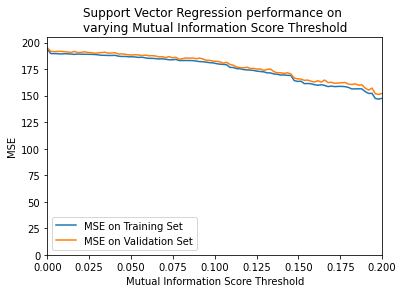

In [42]:
start_time = time.time()
svr = SVR(kernel = "rbf")
feature_curve('Support Vector Regression', svr, XX, YY, np.linspace(0, 0.20, num=100) ,np.linspace(0, 0.20, num=9))
print("Time taken: ", time.time() - start_time)

In [43]:
best_fs_threshold = 0.1979798# from the above feature curve

Grid Search Cross Validation for Hyperparameter Tuning

In [44]:
start_time = time.time()

param_grid = {"C": np.logspace(-3, 4, num=8), "gamma": np.logspace(-9, 4, num=14), "epsilon": np.logspace(-3, 6, num=10)}

svr = GridSearchCV(estimator = SVR(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error")

svr.fit(reduce_by_fs_score(XX_train,YY_train, best_fs_threshold), YY_train)

svr_init_params = svr.best_params_

print("Time taken: ", time.time() - start_time)

Time taken:  75.80362105369568


In [45]:
print(svr.best_params_)

{'C': 10.0, 'epsilon': 1.0, 'gamma': 1.0}


Finer Hyperparameter tuning

Tuning epsilon

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  120.5173032283783


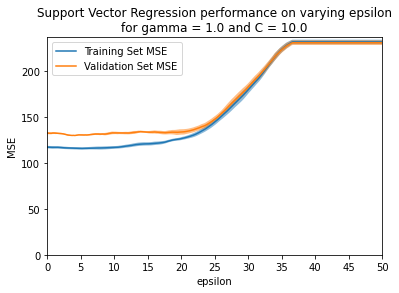

In [46]:
start_time = time.time()
svr = SVR(kernel = "rbf", gamma = svr_init_params['gamma'], C = svr_init_params['C'])
extra_string = '\nfor gamma = ' + str(svr_init_params['gamma']) + ' and C = ' + str(svr_init_params['C'])
param_grid = {"epsilon": np.linspace(0, 50, num=500)}
validation_curve('Support Vector Regression', svr, reduce_by_fs_score(XX,YY, best_fs_threshold),
                 YY, param_grid, False, extra_string, np.linspace(0, 50, num=11))
print("Time taken: ", time.time() - start_time)

Tuning gamma

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  300.92106080055237


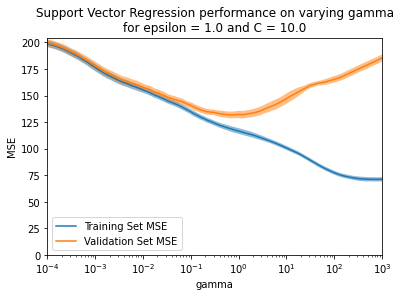

In [47]:
start_time = time.time()
svr = SVR(kernel = "rbf", epsilon = svr_init_params['epsilon'], C = svr_init_params['C'])
extra_string = '\nfor epsilon = ' + str(svr_init_params['epsilon']) + ' and C = ' + str(svr_init_params['C'])
param_grid = {"gamma": np.logspace(-4, 3, num=500)}
validation_curve('Support Vector Regression', svr, reduce_by_fs_score(XX,YY, best_fs_threshold),
                 YY, param_grid, True, extra_string, np.logspace(-4, 3, num=8))
print("Time taken: ", time.time() - start_time)

Tuning C

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  291.2564182281494


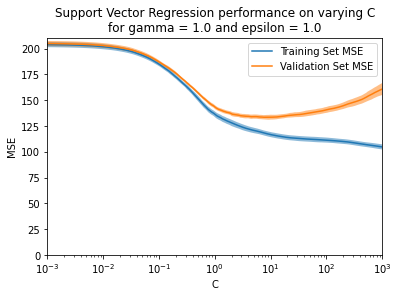

In [48]:
start_time = time.time()
svr = SVR(kernel = "rbf", gamma = svr_init_params['gamma'], epsilon = svr_init_params['epsilon'])
extra_string = '\nfor gamma = ' + str(svr_init_params['gamma']) + ' and epsilon = ' + str(svr_init_params['epsilon'])
param_grid = {"C": np.logspace(-3, 3, num=500)}
validation_curve('Support Vector Regression', svr, reduce_by_fs_score(XX,YY, best_fs_threshold),
                 YY, param_grid, True, extra_string, np.logspace(-3, 3, num=7))
print("Time taken: ", time.time() - start_time)

Predicted vs True

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.46577803166671433
Test Mean Squared Error =  137.9129733621151
Train Mean Squared Error =  117.43130613105308
Time taken:  1127.5796070098877


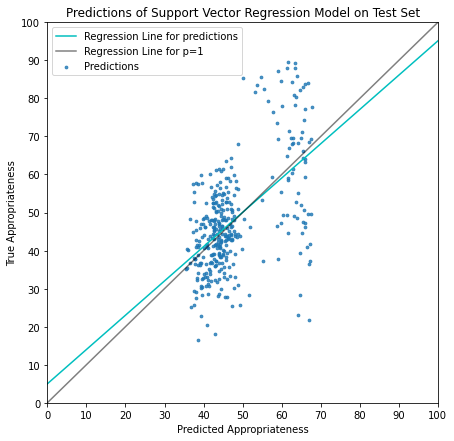

In [49]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"C": np.logspace(-3, 3, num=20), "gamma": np.logspace(-4, 3, num=20), "epsilon": np.linspace(0, 50, num=20)}
svr = GridSearchCV(estimator = SVR(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Support Vector Regression', svr, reduce_by_fs_score(XX,YY, best_fs_threshold), YY)
print("Time taken: ", time.time() - start_time)

# Linear Regression

Feature Selection

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Best Mutual Information Score Threshold:  [0.16363636]
Time taken:  225.14942479133606


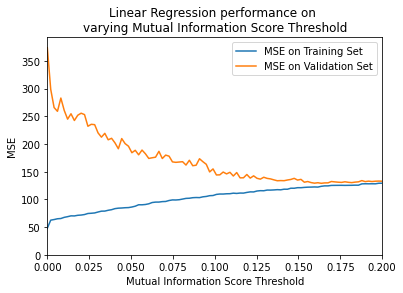

In [50]:
start_time = time.time()
feature_curve('Linear Regression', LinearRegression(), XX, YY, np.linspace(0, 0.20, num=100) ,np.linspace(0, 0.20, num=9))
print("Time taken: ", time.time() - start_time)

In [51]:
best_fs_threshold = 0.16363636# from the above feature curve

Predicted vs True

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.4242729184863981
Test Mean Squared Error =  137.8782261826336
Train Mean Squared Error =  124.47113424865793
Time taken:  0.8499650955200195


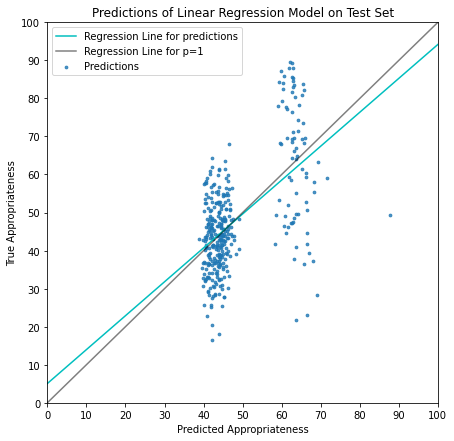

In [52]:
start_time = time.time()
predicted_vs_true('Linear Regression', LinearRegression(), reduce_by_fs_score(XX, YY, best_fs_threshold), YY)
print("Time taken: ", time.time() - start_time)

# Ridge Regression

Feature Selection

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Best Mutual Information Score Threshold:  [0.14949495]
Time taken:  1112.5506529808044


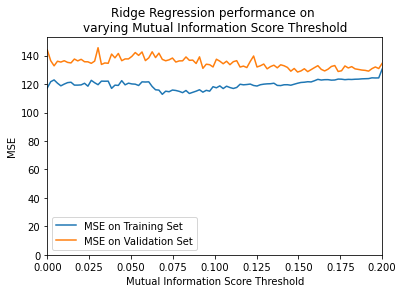

In [53]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"alpha": np.logspace(-5,15, 10)}
ridge_model = GridSearchCV(estimator = Ridge(), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
feature_curve('Ridge Regression', ridge_model, XX, YY, np.linspace(0, 0.20, num=100) ,np.linspace(0, 0.20, num=9))
print("Time taken: ", time.time() - start_time)

In [54]:
best_fs_threshold = 0.14949495# from the above feature curve

Tuning alpha

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  190.9983139038086


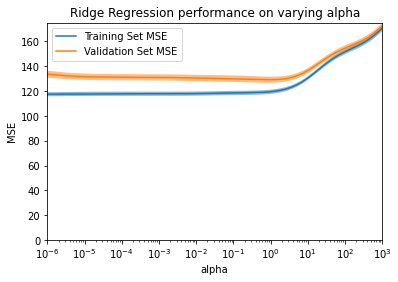

In [55]:
start_time = time.time()
validation_curve('Ridge Regression', Ridge(), reduce_by_fs_score(XX,YY, best_fs_threshold),
                 YY, {"alpha": np.logspace(-6,3, 1000)}, True, '', np.logspace(-6,3,10))
print("Time taken: ", time.time() - start_time)

Predicted vs True

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.5492586838611071
Test Mean Squared Error =  127.47023115504922
Train Mean Squared Error =  120.43143344370627
Time taken:  132.5618793964386


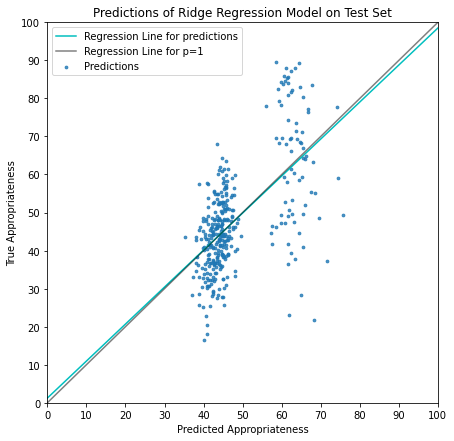

In [56]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"alpha": np.logspace(-6,3, 1000)}
ridge_model = GridSearchCV(estimator = Ridge(), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Ridge Regression', ridge_model, reduce_by_fs_score(XX,YY, best_fs_threshold), YY)
print("Time taken: ", time.time() - start_time)

# Kernel Ridge Regression

Feature Selection

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Best Mutual Information Score Threshold:  [0.01010101]
Time taken:  283.1786370277405


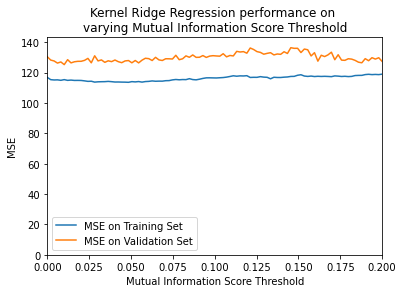

In [57]:
start_time = time.time()
krr = KernelRidge(kernel = "rbf")
feature_curve('Kernel Ridge Regression', krr, XX, YY, np.linspace(0, 0.20, num=100) ,np.linspace(0, 0.20, num=9))
print("Time taken: ", time.time() - start_time)

In [13]:
best_fs_threshold = 0.01010101# from the above feature curve

Grid Search for hyperparameter intialisations

In [14]:
start_time = time.time()

param_grid = {"alpha": np.logspace(-10,5, 16), "gamma": np.logspace(-10, 5, 16)}
kfolds = KFold(n_splits = 5, shuffle = True)
krr = GridSearchCV(estimator = KernelRidge(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv=kfolds, verbose = 3)
krr.fit(reduce_by_fs_score(XX_train,YY_train, best_fs_threshold), YY_train)

krr_init_params = krr.best_params_
print("Time taken: ", time.time() - start_time)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV 1/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 2/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 3/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 4/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 5/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 1/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 2/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 3/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 4/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 5/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 1/5] END .......................alpha=1e-10, gamma=1e-08; total time=   0.0s
[CV 2/5] END .......................alpha=1e-

[CV 2/5] END ......................alpha=1e-09, gamma=0.0001; total time=   0.0s
[CV 3/5] END ......................alpha=1e-09, gamma=0.0001; total time=   0.0s
[CV 4/5] END ......................alpha=1e-09, gamma=0.0001; total time=   0.0s
[CV 5/5] END ......................alpha=1e-09, gamma=0.0001; total time=   0.0s
[CV 1/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 2/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 3/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 4/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 5/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 1/5] END ........................alpha=1e-09, gamma=0.01; total time=   0.0s
[CV 2/5] END ........................alpha=1e-09, gamma=0.01; total time=   0.0s
[CV 3/5] END ........................alpha=1e-09, gamma=0.01; total time=   0.0s
[CV 4/5] END ...............

[CV 3/5] END ......................alpha=1e-08, gamma=1000.0; total time=   0.0s
[CV 4/5] END ......................alpha=1e-08, gamma=1000.0; total time=   0.0s
[CV 5/5] END ......................alpha=1e-08, gamma=1000.0; total time=   0.0s
[CV 1/5] END .....................alpha=1e-08, gamma=10000.0; total time=   0.0s
[CV 2/5] END .....................alpha=1e-08, gamma=10000.0; total time=   0.0s
[CV 3/5] END .....................alpha=1e-08, gamma=10000.0; total time=   0.0s
[CV 4/5] END .....................alpha=1e-08, gamma=10000.0; total time=   0.0s
[CV 5/5] END .....................alpha=1e-08, gamma=10000.0; total time=   0.0s
[CV 1/5] END ....................alpha=1e-08, gamma=100000.0; total time=   0.0s
[CV 2/5] END ....................alpha=1e-08, gamma=100000.0; total time=   0.0s
[CV 3/5] END ....................alpha=1e-08, gamma=100000.0; total time=   0.0s
[CV 4/5] END ....................alpha=1e-08, gamma=100000.0; total time=   0.0s
[CV 5/5] END ...............

[CV 2/5] END .......................alpha=1e-06, gamma=1e-07; total time=   0.0s
[CV 3/5] END .......................alpha=1e-06, gamma=1e-07; total time=   0.0s
[CV 4/5] END .......................alpha=1e-06, gamma=1e-07; total time=   0.0s
[CV 5/5] END .......................alpha=1e-06, gamma=1e-07; total time=   0.0s
[CV 1/5] END .......................alpha=1e-06, gamma=1e-06; total time=   0.0s
[CV 2/5] END .......................alpha=1e-06, gamma=1e-06; total time=   0.0s
[CV 3/5] END .......................alpha=1e-06, gamma=1e-06; total time=   0.0s
[CV 4/5] END .......................alpha=1e-06, gamma=1e-06; total time=   0.0s
[CV 5/5] END .......................alpha=1e-06, gamma=1e-06; total time=   0.0s
[CV 1/5] END .......................alpha=1e-06, gamma=1e-05; total time=   0.0s
[CV 2/5] END .......................alpha=1e-06, gamma=1e-05; total time=   0.0s
[CV 3/5] END .......................alpha=1e-06, gamma=1e-05; total time=   0.0s
[CV 4/5] END ...............

[CV 5/5] END .......................alpha=1e-05, gamma=0.001; total time=   0.0s
[CV 1/5] END ........................alpha=1e-05, gamma=0.01; total time=   0.0s
[CV 2/5] END ........................alpha=1e-05, gamma=0.01; total time=   0.0s
[CV 3/5] END ........................alpha=1e-05, gamma=0.01; total time=   0.0s
[CV 4/5] END ........................alpha=1e-05, gamma=0.01; total time=   0.0s
[CV 5/5] END ........................alpha=1e-05, gamma=0.01; total time=   0.0s
[CV 1/5] END .........................alpha=1e-05, gamma=0.1; total time=   0.0s
[CV 2/5] END .........................alpha=1e-05, gamma=0.1; total time=   0.0s
[CV 3/5] END .........................alpha=1e-05, gamma=0.1; total time=   0.0s
[CV 4/5] END .........................alpha=1e-05, gamma=0.1; total time=   0.0s
[CV 5/5] END .........................alpha=1e-05, gamma=0.1; total time=   0.0s
[CV 1/5] END .........................alpha=1e-05, gamma=1.0; total time=   0.0s
[CV 2/5] END ...............

[CV 4/5] END .....................alpha=0.0001, gamma=1000.0; total time=   0.0s
[CV 5/5] END .....................alpha=0.0001, gamma=1000.0; total time=   0.0s
[CV 1/5] END ....................alpha=0.0001, gamma=10000.0; total time=   0.0s
[CV 2/5] END ....................alpha=0.0001, gamma=10000.0; total time=   0.0s
[CV 3/5] END ....................alpha=0.0001, gamma=10000.0; total time=   0.0s
[CV 4/5] END ....................alpha=0.0001, gamma=10000.0; total time=   0.0s
[CV 5/5] END ....................alpha=0.0001, gamma=10000.0; total time=   0.0s
[CV 1/5] END ...................alpha=0.0001, gamma=100000.0; total time=   0.0s
[CV 2/5] END ...................alpha=0.0001, gamma=100000.0; total time=   0.0s
[CV 3/5] END ...................alpha=0.0001, gamma=100000.0; total time=   0.0s
[CV 4/5] END ...................alpha=0.0001, gamma=100000.0; total time=   0.0s
[CV 5/5] END ...................alpha=0.0001, gamma=100000.0; total time=   0.0s
[CV 1/5] END ...............

[CV 3/5] END ........................alpha=0.01, gamma=1e-06; total time=   0.0s
[CV 4/5] END ........................alpha=0.01, gamma=1e-06; total time=   0.0s
[CV 5/5] END ........................alpha=0.01, gamma=1e-06; total time=   0.0s
[CV 1/5] END ........................alpha=0.01, gamma=1e-05; total time=   0.0s
[CV 2/5] END ........................alpha=0.01, gamma=1e-05; total time=   0.0s
[CV 3/5] END ........................alpha=0.01, gamma=1e-05; total time=   0.0s
[CV 4/5] END ........................alpha=0.01, gamma=1e-05; total time=   0.0s
[CV 5/5] END ........................alpha=0.01, gamma=1e-05; total time=   0.0s
[CV 1/5] END .......................alpha=0.01, gamma=0.0001; total time=   0.0s
[CV 2/5] END .......................alpha=0.01, gamma=0.0001; total time=   0.0s
[CV 3/5] END .......................alpha=0.01, gamma=0.0001; total time=   0.0s
[CV 4/5] END .......................alpha=0.01, gamma=0.0001; total time=   0.0s
[CV 5/5] END ...............

[CV 3/5] END ...........................alpha=0.1, gamma=1.0; total time=   0.0s
[CV 4/5] END ...........................alpha=0.1, gamma=1.0; total time=   0.0s
[CV 5/5] END ...........................alpha=0.1, gamma=1.0; total time=   0.0s
[CV 1/5] END ..........................alpha=0.1, gamma=10.0; total time=   0.0s
[CV 2/5] END ..........................alpha=0.1, gamma=10.0; total time=   0.0s
[CV 3/5] END ..........................alpha=0.1, gamma=10.0; total time=   0.0s
[CV 4/5] END ..........................alpha=0.1, gamma=10.0; total time=   0.0s
[CV 5/5] END ..........................alpha=0.1, gamma=10.0; total time=   0.0s
[CV 1/5] END .........................alpha=0.1, gamma=100.0; total time=   0.0s
[CV 2/5] END .........................alpha=0.1, gamma=100.0; total time=   0.0s
[CV 3/5] END .........................alpha=0.1, gamma=100.0; total time=   0.0s
[CV 4/5] END .........................alpha=0.1, gamma=100.0; total time=   0.0s
[CV 5/5] END ...............

[CV 3/5] END ......................alpha=1.0, gamma=100000.0; total time=   0.0s
[CV 4/5] END ......................alpha=1.0, gamma=100000.0; total time=   0.0s
[CV 5/5] END ......................alpha=1.0, gamma=100000.0; total time=   0.0s
[CV 1/5] END ........................alpha=10.0, gamma=1e-10; total time=   0.0s
[CV 2/5] END ........................alpha=10.0, gamma=1e-10; total time=   0.0s
[CV 3/5] END ........................alpha=10.0, gamma=1e-10; total time=   0.0s
[CV 4/5] END ........................alpha=10.0, gamma=1e-10; total time=   0.0s
[CV 5/5] END ........................alpha=10.0, gamma=1e-10; total time=   0.0s
[CV 1/5] END ........................alpha=10.0, gamma=1e-09; total time=   0.0s
[CV 2/5] END ........................alpha=10.0, gamma=1e-09; total time=   0.0s
[CV 3/5] END ........................alpha=10.0, gamma=1e-09; total time=   0.0s
[CV 4/5] END ........................alpha=10.0, gamma=1e-09; total time=   0.0s
[CV 5/5] END ...............

[CV 4/5] END .......................alpha=100.0, gamma=1e-05; total time=   0.0s
[CV 5/5] END .......................alpha=100.0, gamma=1e-05; total time=   0.0s
[CV 1/5] END ......................alpha=100.0, gamma=0.0001; total time=   0.0s
[CV 2/5] END ......................alpha=100.0, gamma=0.0001; total time=   0.0s
[CV 3/5] END ......................alpha=100.0, gamma=0.0001; total time=   0.0s
[CV 4/5] END ......................alpha=100.0, gamma=0.0001; total time=   0.0s
[CV 5/5] END ......................alpha=100.0, gamma=0.0001; total time=   0.0s
[CV 1/5] END .......................alpha=100.0, gamma=0.001; total time=   0.0s
[CV 2/5] END .......................alpha=100.0, gamma=0.001; total time=   0.0s
[CV 3/5] END .......................alpha=100.0, gamma=0.001; total time=   0.0s
[CV 4/5] END .......................alpha=100.0, gamma=0.001; total time=   0.0s
[CV 5/5] END .......................alpha=100.0, gamma=0.001; total time=   0.0s
[CV 1/5] END ...............

[CV 4/5] END ......................alpha=1000.0, gamma=100.0; total time=   0.0s
[CV 5/5] END ......................alpha=1000.0, gamma=100.0; total time=   0.0s
[CV 1/5] END .....................alpha=1000.0, gamma=1000.0; total time=   0.0s
[CV 2/5] END .....................alpha=1000.0, gamma=1000.0; total time=   0.0s
[CV 3/5] END .....................alpha=1000.0, gamma=1000.0; total time=   0.0s
[CV 4/5] END .....................alpha=1000.0, gamma=1000.0; total time=   0.0s
[CV 5/5] END .....................alpha=1000.0, gamma=1000.0; total time=   0.0s
[CV 1/5] END ....................alpha=1000.0, gamma=10000.0; total time=   0.0s
[CV 2/5] END ....................alpha=1000.0, gamma=10000.0; total time=   0.0s
[CV 3/5] END ....................alpha=1000.0, gamma=10000.0; total time=   0.0s
[CV 4/5] END ....................alpha=1000.0, gamma=10000.0; total time=   0.0s
[CV 5/5] END ....................alpha=1000.0, gamma=10000.0; total time=   0.0s
[CV 1/5] END ...............

[CV 2/5] END ....................alpha=100000.0, gamma=1e-07; total time=   0.0s
[CV 3/5] END ....................alpha=100000.0, gamma=1e-07; total time=   0.0s
[CV 4/5] END ....................alpha=100000.0, gamma=1e-07; total time=   0.0s
[CV 5/5] END ....................alpha=100000.0, gamma=1e-07; total time=   0.0s
[CV 1/5] END ....................alpha=100000.0, gamma=1e-06; total time=   0.0s
[CV 2/5] END ....................alpha=100000.0, gamma=1e-06; total time=   0.0s
[CV 3/5] END ....................alpha=100000.0, gamma=1e-06; total time=   0.0s
[CV 4/5] END ....................alpha=100000.0, gamma=1e-06; total time=   0.0s
[CV 5/5] END ....................alpha=100000.0, gamma=1e-06; total time=   0.0s
[CV 1/5] END ....................alpha=100000.0, gamma=1e-05; total time=   0.0s
[CV 2/5] END ....................alpha=100000.0, gamma=1e-05; total time=   0.0s
[CV 3/5] END ....................alpha=100000.0, gamma=1e-05; total time=   0.0s
[CV 4/5] END ...............

In [15]:
print(krr_init_params)

{'alpha': 0.1, 'gamma': 0.001}


Tuning Alpha

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  453.07955169677734


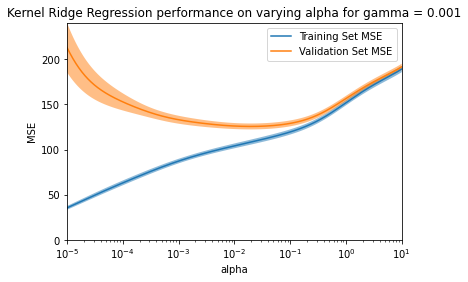

In [16]:
start_time = time.time()
krr = KernelRidge(kernel = "rbf", gamma = krr_init_params['gamma'])
extra_string = ' for gamma = ' + str(krr_init_params['gamma'])
param_grid = {"alpha": np.logspace(-5,1, 1000)}
validation_curve('Kernel Ridge Regression', krr, reduce_by_fs_score(XX,YY, best_fs_threshold),
                 YY, param_grid, True, extra_string, np.logspace(-5,1, 7))
print("Time taken: ", time.time() - start_time)

Tuning Gamma

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  512.6094331741333


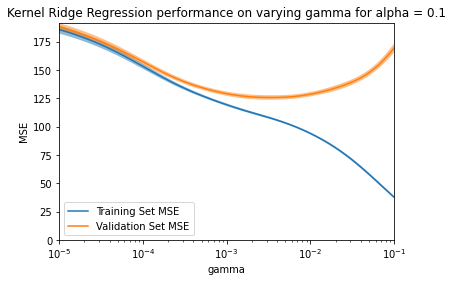

In [17]:
start_time = time.time()
krr = KernelRidge(kernel = "rbf", alpha = krr_init_params['alpha'])
extra_string = ' for alpha = ' + str(krr_init_params['alpha'])
param_grid = {"gamma": np.logspace(-5,-1, 1000)}
validation_curve('Kernel Ridge Regression', krr, reduce_by_fs_score(XX,YY, best_fs_threshold),
                 YY, param_grid, True, extra_string, np.logspace(-5,-1, 5))
print("Time taken: ", time.time() - start_time)

Predicted vs True

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.5770212669644831
Test Mean Squared Error =  136.55557492149782
Train Mean Squared Error =  95.26946781696091
Time taken:  611.6054434776306


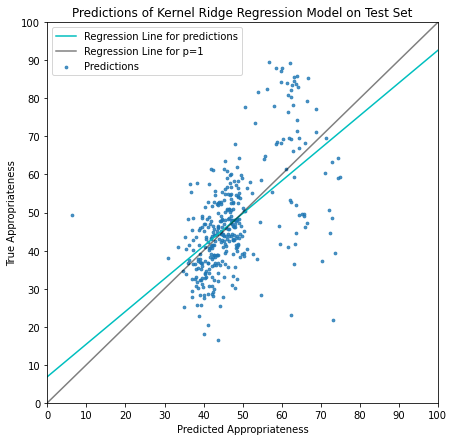

In [18]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"alpha": np.logspace(-5,1, 50), "gamma": np.logspace(-5,-1, 50)}
krr_model = GridSearchCV(estimator = KernelRidge(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Kernel Ridge Regression', krr_model, reduce_by_fs_score(XX,YY, best_fs_threshold), YY)
print("Time taken: ", time.time() - start_time)

# kNN Regression

Feature Selection

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Best Mutual Information Score Threshold:  [0.00808081]
Time taken:  1007.4954035282135


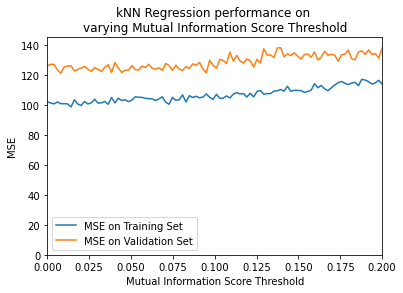

In [20]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"n_neighbors": np.arange(1,41,5)}
knn = KNeighborsRegressor()
knn_model = GridSearchCV(estimator = knn, param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
feature_curve('kNN Regression', knn_model, XX, YY, np.linspace(0, 0.20, num=100) ,np.linspace(0, 0.20, num=9))
print("Time taken: ", time.time() - start_time)

In [21]:
best_fs_threshold = 0.00808081# from the above feature curve

Tune n_neighbors for weights = "uniform"

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  15.12132716178894


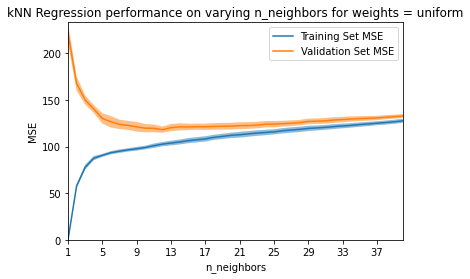

In [22]:
start_time = time.time()
knn = KNeighborsRegressor(weights = 'uniform')
extra_string = ' for weights = uniform'
param_grid = {"n_neighbors": np.arange(1,41,1)}
validation_curve('kNN Regression', knn, reduce_by_fs_score(XX,YY, best_fs_threshold),
                 YY, param_grid, False, extra_string, np.arange(1,41,4))
print("Time taken: ", time.time() - start_time)

Tune n_neighbors for weights = "distance"

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  15.502808094024658


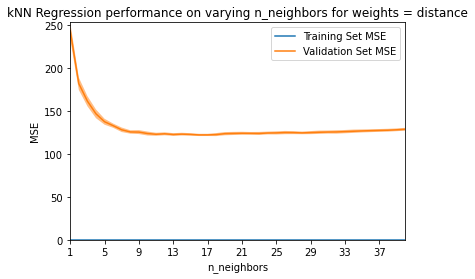

In [23]:
start_time = time.time()
knn = KNeighborsRegressor(weights = 'distance')
extra_string = ' for weights = distance'
param_grid = {"n_neighbors": np.arange(1,41,1)}
validation_curve('kNN Regression', knn, reduce_by_fs_score(XX,YY, best_fs_threshold),
                 YY, param_grid, False, extra_string, np.arange(1,41,4))
print("Time taken: ", time.time() - start_time)

Predicted VS True

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.5934982074498659
Test Mean Squared Error =  117.46297272700495
Train Mean Squared Error =  102.1037399299595
Time taken:  19.288371562957764


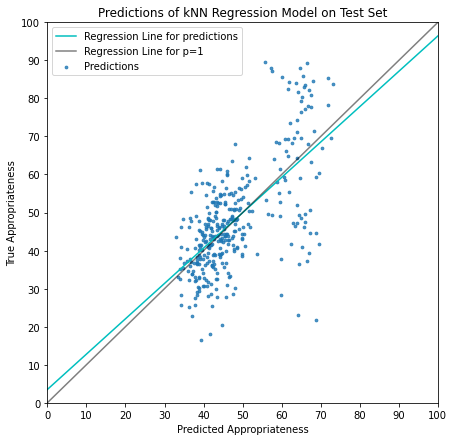

In [24]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"n_neighbors": np.arange(1,41,1), "weights": ["uniform", "distance"]}
knn_model = GridSearchCV(estimator = KNeighborsRegressor(), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('kNN Regression', knn_model, reduce_by_fs_score(XX,YY, best_fs_threshold), YY)
print("Time taken: ", time.time() - start_time)